# Imputation Research Project <img src="https://chroniclesofai.com/content/images/2021/05/file-20201210-18-elk4m.jpg" alt="Alt text image not displaying" width="360" align="right" />
## Notebook 3.0: Autoencoder Model

**Author:** Chike Odenigbo

**Date:** November 25th, 2022

**Notebook Structure:**

* 1.0 Preprocessing

* **1.1 Exploratory Data Analysis**

* 1.2 Masking

* 2.* Models


Water Sugar lutein_zeaxanthin Alcohol

In [1]:
import pandas as pd
import os
from src.visualization.visualize import histogram, box_plot, bar_plot, line_plot
from pathlib import Path
from notebook_config import ROOT_DIR  # setup.py file changed the root of the project so it is set in the config file

ROOT_DIR = ROOT_DIR.as_posix()  # convert root path to windows readable path (i.e. change backslash to forward slash)
from joblib import load
import tensorflow as tf
from keras import backend as K
import keras
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import mean_squared_error

In [2]:
notebook_nm = "3.1-autoencoder-perf-eval"
fig_dir = f"{ROOT_DIR}/reports/figures/"
model_dir = f"{ROOT_DIR}/models/autoencoders/"
scaler_dir = f'{ROOT_DIR}/models/scalers/'
stats_data_dir = f'{ROOT_DIR}/data/interim/'
output_prefix = notebook_nm

In [3]:
pd.set_option('display.max_columns', None)

# Ground Truth Included
water_df = pd.read_csv(f'{ROOT_DIR}/data/processed/water.csv')
sugars_df = pd.read_csv(f'{ROOT_DIR}/data/processed/sugars.csv')
lutein_df = pd.read_csv(f'{ROOT_DIR}/data/processed/lutein.csv')

# nutrient stats 
nutrient_stats_df = pd.read_csv(f'{stats_data_dir}/nutrition_facts_statistics.csv')

# Scaled Data without Ground Truth to prevent Data Leakage, rows are included with NaN
water_mcar_scaled_df = pd.read_csv(f'{ROOT_DIR}/data/processed/water_mcar_scaled.csv', index_col = 0)
water_mar_scaled_df = pd.read_csv(f'{ROOT_DIR}/data/processed/water_mar_scaled.csv', index_col = 0)

lutein_mar_scaled_df = pd.read_csv(f'{ROOT_DIR}/data/processed/lutein_mar_scaled.csv', index_col = 0)
lutein_mcar_scaled_df = pd.read_csv(f'{ROOT_DIR}/data/processed/utein_mcar_scaled.csv', index_col = 0)

sugars_mar_scaled_df = pd.read_csv(f'{ROOT_DIR}/data/processed/sugars_mar_scaled.csv', index_col = 0)
sugars_mcar_scaled_df = pd.read_csv(f'{ROOT_DIR}/data/processed/sugars_mcar_scaled.csv', index_col = 0)

water_mcar_scaled_df = pd.read_csv(f'{ROOT_DIR}/data/processed/water_mcar_scaled.csv', index_col = 0)
water_mar_scaled_df = pd.read_csv(f'{ROOT_DIR}/data/processed/water_mar_scaled.csv', index_col = 0)

# Scalers to return back to origin scale for model evaluation
scaler_lutein_mar = load(f'{scaler_dir}/scaler_lutein_mar.joblib')
scaler_lutein_mcar = load(f'{scaler_dir}/scaler_lutein_mcar.joblib')

scaler_sugars_mar = load(f'{scaler_dir}/scaler_sugars_mar.joblib')
scaler_sugars_mcar = load(f'{scaler_dir}/scaler_sugars_mcar.joblib')

scaler_water_mcar = load(f'{scaler_dir}/scaler_water_mcar.joblib')
scaler_water_mar = load(f'{scaler_dir}/scaler_water_mar.joblib')


In [4]:
def scale_ground_truth(scaler,raw_df,target_col,non_target_na_col):
    raw_filtered_df = raw_df[raw_df[target_col].isnull()].drop([target_col, non_target_na_col], axis = 'columns').set_index('name')
    scaled_ground_truth_df = pd.DataFrame(scaler.transform(raw_filtered_df),columns = raw_filtered_df.columns, index = raw_filtered_df.index)
    return scaled_ground_truth_df

def train_test_split_scaled(scaled_df,drop_cols = ['name','dataset_type']):
    train_df = scaled_df[scaled_df.dataset_type == 'training'].drop(drop_cols, axis = 'columns')
    val_df = scaled_df[scaled_df.dataset_type == 'validation'].drop(drop_cols, axis = 'columns')
    return train_df, val_df

def load_autoencoder(model_name,path = model_dir):
    model = keras.models.load_model(f'{model_dir}/{model_name}.h5')
    file = open(f'{path}/{model_name}_history.pkl','rb')
    history = pickle.load(file)
    return model,history

def impute_validation_for_prediction(train_data,val_data,target_col,constant_impute_val = 0):
    """
    can't pass null value to the tensorflow predict method so we impute with constant and random 
    and take the aggregate performance of the two 
    """
    max_target = train_data[target_col].max()
    min_target = train_data[target_col].min()
    val_data_constant = val_data.copy()
    val_data_random = val_data.copy()
    val_data_random[target_col] = np.random.uniform(min_target, max_target, size=len(val_data))
    val_data_constant[target_col] = constant_impute_val
    return val_data_random, val_data_constant

def predict(model,test_data):
    pred_data = pd.DataFrame(model.predict(test_data), columns = test_data.columns, index = test_data.index)
    return pred_data

def inverse_scale_predictions(scaler,predictions):
    unscaled_pred = pd.DataFrame(scaler.inverse_transform(predictions), columns = predictions.columns, index = predictions.index)
    return unscaled_pred

def mse_all_predictions(mcar_ground_truth_scaled_df, mar_ground_truth_scaled_df, mcar_rand_pred,mar_rand_pred,mcar_const_pred,mar_const_pred, mcar_ground_truth_unscaled_df,mar_ground_truth_unscaled_df, mcar_pred_rand_unscaled_df,mar_pred_rand_unscaled_df, mcar_pred_const_unscaled_df, mar_pred_const_unscaled_df):
    result_df = pd.DataFrame({'nutrient':mcar_ground_truth_scaled_df.columns,
              'rmse_mcar_rand_scaled':list(mean_squared_error(mcar_ground_truth_scaled_df, mcar_rand_pred, multioutput='raw_values', squared = False)),
              'rmse_mar_rand_scaled':list(mean_squared_error(mar_ground_truth_scaled_df, mar_rand_pred, multioutput='raw_values', squared = False)),
              'rmse_mcar_const_scaled':list(mean_squared_error(mcar_ground_truth_scaled_df, mcar_const_pred, multioutput='raw_values', squared = False)),
              'rmse_mar_const_scaled':list(mean_squared_error(mar_ground_truth_scaled_df, mar_const_pred, multioutput='raw_values', squared = False)),
              
              'rmse_mcar_rand_unscaled':list(mean_squared_error(mcar_ground_truth_unscaled_df, mcar_pred_rand_unscaled_df, multioutput='raw_values', squared = False)),
              'rmse_mar_rand_unscaled':list(mean_squared_error(mar_ground_truth_unscaled_df, mar_pred_rand_unscaled_df, multioutput='raw_values', squared = False)),
              'rmse_mcar_const_unscaled':list(mean_squared_error(mcar_ground_truth_unscaled_df, mcar_pred_const_unscaled_df, multioutput='raw_values', squared = False)),
              'rmse_mar_const_unscaled':list(mean_squared_error(mar_ground_truth_unscaled_df, mar_pred_const_unscaled_df, multioutput='raw_values', squared = False))})
    return result_df

In [5]:
water_mcar_ground_truth_unscaled_df = water_df[water_df.water_mcar.isnull()].drop(['water_mcar','water_mar'], axis = 'columns').set_index('name')
water_mar_ground_truth_unscaled_df = water_df[water_df.water_mar.isnull()].drop(['water_mcar','water_mar'], axis = 'columns').set_index('name')

lutein_mcar_ground_truth_unscaled_df = lutein_df[lutein_df.lutein_zeaxanthin_mcar.isnull()].drop(['lutein_zeaxanthin_mcar','lutein_zeaxanthin_mar'], axis = 'columns').set_index('name')
lutein_mar_ground_truth_unscaled_df = lutein_df[lutein_df.lutein_zeaxanthin_mar.isnull()].drop(['lutein_zeaxanthin_mcar','lutein_zeaxanthin_mar'], axis = 'columns').set_index('name')

sugars_mcar_ground_truth_unscaled_df = sugars_df[sugars_df.sugars_mcar.isnull()].drop(['sugars_mcar','sugars_mar'], axis = 'columns').set_index('name')
sugars_mar_ground_truth_unscaled_df = sugars_df[sugars_df.sugars_mar.isnull()].drop(['sugars_mcar','sugars_mar'], axis = 'columns').set_index('name')

In [6]:
water_mar_val_rand, water_mar_val_const = impute_validation_for_prediction(water_mar_scaled_df[water_mar_scaled_df.dataset_type == 'training'].drop(['name','dataset_type'], axis = 'columns'),water_mar_scaled_df[water_mar_scaled_df.dataset_type == 'validation'].drop(['dataset_type'], axis = 'columns').set_index('name'),target_col = 'water_mar',constant_impute_val = 0)
water_mcar_val_rand, water_mcar_val_const = impute_validation_for_prediction(water_mcar_scaled_df[water_mcar_scaled_df.dataset_type == 'training'].drop(['name','dataset_type'], axis = 'columns'),water_mcar_scaled_df[water_mcar_scaled_df.dataset_type == 'validation'].drop(['dataset_type'], axis = 'columns').set_index('name'),target_col = 'water_mcar',constant_impute_val = 0)

sugars_mar_val_rand, sugars_mar_val_const = impute_validation_for_prediction(sugars_mar_scaled_df[sugars_mar_scaled_df.dataset_type == 'training'].drop(['name','dataset_type'], axis = 'columns'),sugars_mar_scaled_df[sugars_mar_scaled_df.dataset_type == 'validation'].drop(['dataset_type'], axis = 'columns').set_index('name'),target_col = 'sugars_mar',constant_impute_val = 0)
sugars_mcar_val_rand, sugars_mcar_val_const = impute_validation_for_prediction(sugars_mcar_scaled_df[sugars_mcar_scaled_df.dataset_type == 'training'].drop(['name','dataset_type'], axis = 'columns'),sugars_mcar_scaled_df[sugars_mcar_scaled_df.dataset_type == 'validation'].drop(['dataset_type'], axis = 'columns').set_index('name'),target_col = 'sugars_mcar',constant_impute_val = 0)

lutein_mar_val_rand, lutein_mar_val_const = impute_validation_for_prediction(lutein_mar_scaled_df[lutein_mar_scaled_df.dataset_type == 'training'].drop(['name','dataset_type'], axis = 'columns'),lutein_mar_scaled_df[lutein_mar_scaled_df.dataset_type == 'validation'].drop(['dataset_type'], axis = 'columns').set_index('name'),target_col = 'lutein_zeaxanthin_mar',constant_impute_val = 0)
lutein_mcar_val_rand, lutein_mcar_val_const = impute_validation_for_prediction(lutein_mcar_scaled_df[lutein_mcar_scaled_df.dataset_type == 'training'].drop(['name','dataset_type'], axis = 'columns'),lutein_mcar_scaled_df[lutein_mcar_scaled_df.dataset_type == 'validation'].drop(['dataset_type'], axis = 'columns').set_index('name'),target_col = 'lutein_zeaxanthin_mcar',constant_impute_val = 0)

In [7]:
lutein_mcar_model, lutein_mcar_history = load_autoencoder(model_name = 'lutein_mcar_model',path = model_dir)
lutein_mar_model, lutein_mar_history = load_autoencoder(model_name = 'lutein_mar_model',path = model_dir)

water_mcar_model, water_mcar_history = load_autoencoder(model_name = 'water_mcar_model',path = model_dir)
water_mar_model, water_mar_history = load_autoencoder(model_name = 'water_mar_model',path = model_dir)

sugars_mcar_model, sugars_mcar_history = load_autoencoder(model_name = 'sugars_mcar_model',path = model_dir)
sugars_mar_model, sugars_mar_history = load_autoencoder(model_name = 'sugars_mar_model',path = model_dir)

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2022-11-28 17:04:08         1884
metadata.json                                  2022-11-28 17:04:08           64
variables.h5                                   2022-11-28 17:04:08        36504
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\input_layer
......vars
...metrics\mean
......vars
.........0
.........1
...vars
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2022-11-28 17:04:08         1878
metadata.json                                  2022-11-28 17:04:08           64
variables.h5                                   2022-11-28 17:04:08        36504
Keras weights file (<HDF5 file "variables.h5" 

Image found in the "reports/figures" folder saved under 3.1-autoencoder-perf-eval_model_evaluation_lutein_missing_completely_at_random_lineplot.png
Image found in the "reports/figures" folder saved under 3.1-autoencoder-perf-eval_model_evaluation_lutein_missing_at_random_lineplot.png
Image found in the "reports/figures" folder saved under 3.1-autoencoder-perf-eval_model_evaluation_water_missing_completely_at_random_lineplot.png
Image found in the "reports/figures" folder saved under 3.1-autoencoder-perf-eval_model_evaluation_water_missing_at_random_lineplot.png
Image found in the "reports/figures" folder saved under 3.1-autoencoder-perf-eval_model_evaluation_sugars_missing_completely_at_random_lineplot.png
Image found in the "reports/figures" folder saved under 3.1-autoencoder-perf-eval_model_evaluation_sugars_missing_at_random_lineplot.png


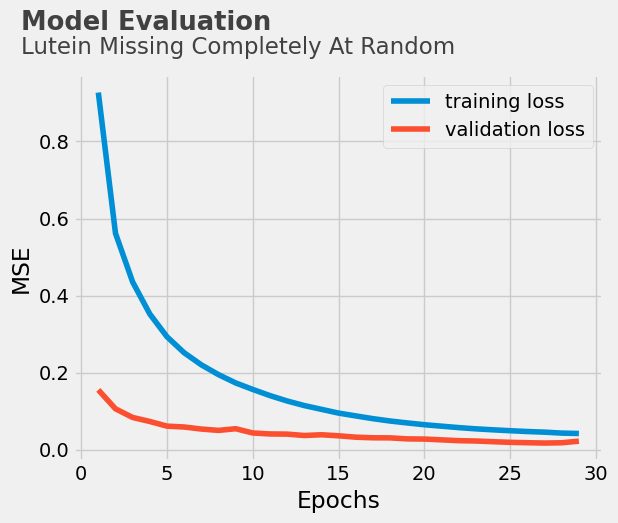

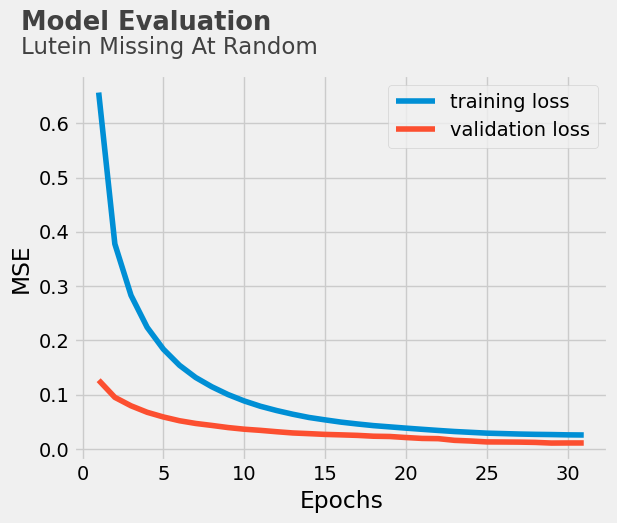

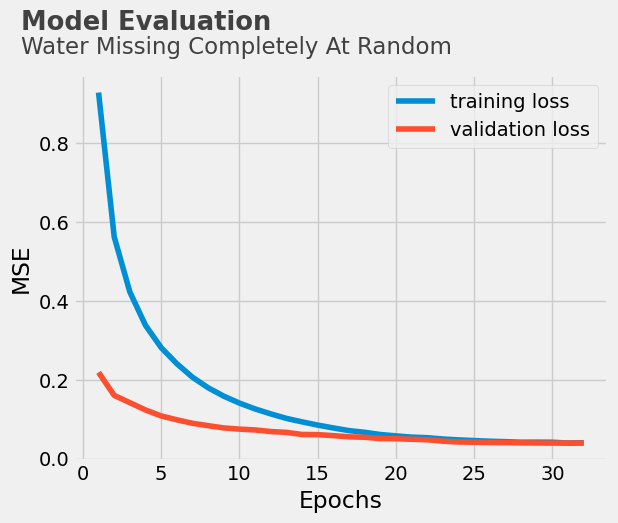

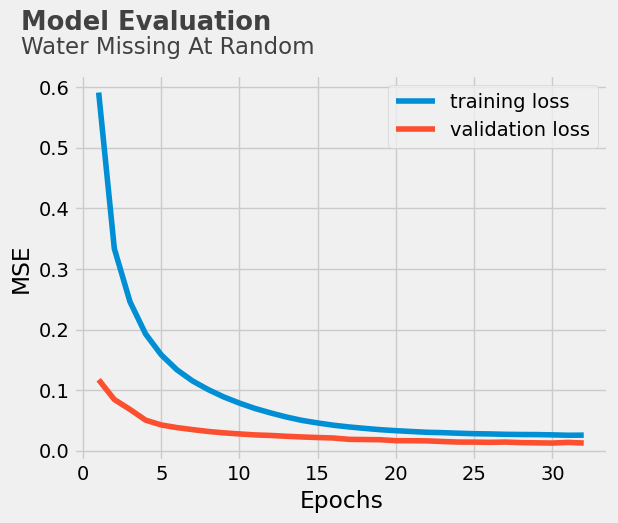

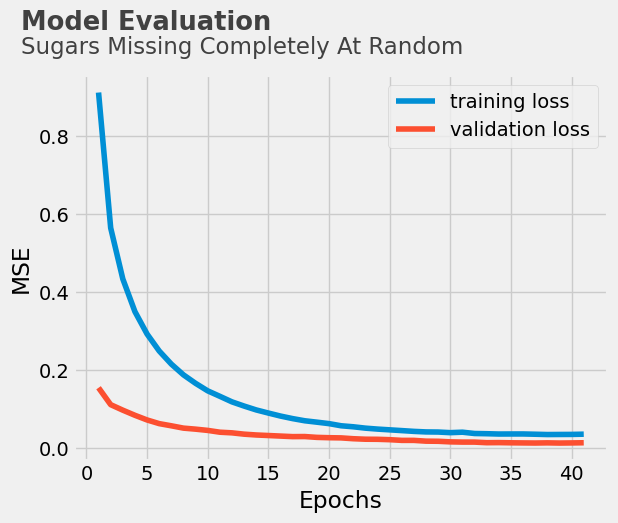

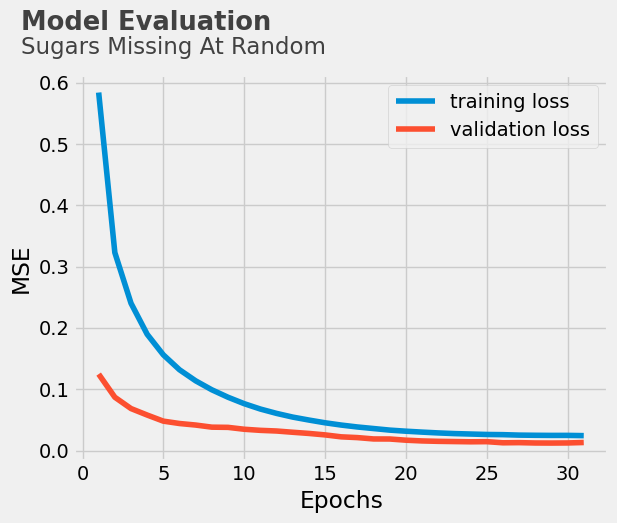

In [8]:
line_plot(history = lutein_mcar_history, fig_dir = fig_dir, output_prefix = output_prefix, subtitle = 'Lutein Missing Completely at Random', title = 'Model Evaluation')
line_plot(history = lutein_mar_history, fig_dir= fig_dir, output_prefix = output_prefix, subtitle = 'Lutein Missing at Random', title = 'Model Evaluation')

line_plot(history = water_mcar_history, fig_dir = fig_dir, output_prefix = output_prefix, subtitle = 'Water Missing Completely at Random', title = 'Model Evaluation')
line_plot(history = water_mar_history, fig_dir = fig_dir, output_prefix = output_prefix, subtitle = 'Water Missing at Random', title = 'Model Evaluation')

line_plot(history = sugars_mcar_history, fig_dir = fig_dir, output_prefix = output_prefix, subtitle = 'Sugars Missing Completely at Random', title = 'Model Evaluation')
line_plot(history = sugars_mar_history, fig_dir = fig_dir, output_prefix = output_prefix, subtitle = 'Sugars Missing at Random', title = 'Model Evaluation')

In [9]:
water_mar_rand_pred = predict(water_mar_model, water_mar_val_rand)
water_mar_const_pred = predict(water_mar_model, water_mar_val_const)
water_mcar_rand_pred = predict(water_mcar_model, water_mcar_val_rand)
water_mcar_const_pred = predict(water_mcar_model, water_mcar_val_const)
sugars_mar_rand_pred = predict(sugars_mar_model, sugars_mar_val_rand)
sugars_mar_const_pred = predict(sugars_mar_model, sugars_mar_val_const)
sugars_mcar_rand_pred = predict(sugars_mcar_model, sugars_mcar_val_rand)
sugars_mcar_const_pred = predict(sugars_mcar_model, sugars_mcar_val_const)
lutein_mar_rand_pred = predict(lutein_mar_model, lutein_mar_val_rand)
lutein_mar_const_pred = predict(lutein_mar_model, lutein_mar_val_const)
lutein_mcar_rand_pred = predict(lutein_mcar_model, lutein_mcar_val_rand)
lutein_mcar_const_pred = predict(lutein_mcar_model, lutein_mcar_val_const)

71/71 [==============================] - 0s 1ms/step


In [10]:
import warnings
warnings.filterwarnings('ignore') 
water_mcar_ground_truth_scaled_df = scale_ground_truth(scaler = scaler_water_mcar,raw_df = water_df,target_col = 'water_mcar',non_target_na_col = 'water_mar')
water_mar_ground_truth_scaled_df = scale_ground_truth(scaler = scaler_water_mar,raw_df = water_df,target_col = 'water_mar',non_target_na_col = 'water_mcar')

sugars_mcar_ground_truth_scaled_df = scale_ground_truth(scaler = scaler_sugars_mcar,raw_df = sugars_df,target_col = 'sugars_mcar',non_target_na_col = 'sugars_mar')
sugars_mar_ground_truth_scaled_df = scale_ground_truth(scaler = scaler_sugars_mar,raw_df = sugars_df,target_col = 'sugars_mar',non_target_na_col = 'sugars_mcar')

lutein_mcar_ground_truth_scaled_df = scale_ground_truth(scaler = scaler_lutein_mcar,raw_df = lutein_df,target_col = 'lutein_zeaxanthin_mcar',non_target_na_col = 'lutein_zeaxanthin_mar')
lutein_mar_ground_truth_scaled_df = scale_ground_truth(scaler = scaler_lutein_mar,raw_df = lutein_df,target_col = 'lutein_zeaxanthin_mar',non_target_na_col = 'lutein_zeaxanthin_mcar')

In [11]:
water_mcar_rand_pred

,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water_mcar
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Teff, uncooked",-0.942487,-0.685543,0.007644,-0.590424,-0.005291,-0.373143,0.064965,-0.289662,0.025411,0.181914,0.088324,-0.136102,-0.104511,-0.208408,-0.145983,0.118369,-0.233125,-0.251153,0.390936,-0.285157,-0.579665,-0.191203,-0.179191,-0.022438,0.891861,0.889132,0.893404,2.111603,1.411591,1.208476,0.099223,-0.238634,0.258306,-0.715114,-0.160935,0.455665,-0.027158,0.528592,0.574314,-0.151121,-0.067915,-0.522066,0.059874,0.097577,-0.323213,0.010522,0.355430,0.377687,0.394133,-0.025508,0.595720,0.182866,0.169550,0.710572,0.812477,-0.460738,0.702139,-0.159594,0.510743,0.142803,-0.175404,0.392723,-0.939452,-0.681500,-1.122318,-0.217767,0.023814,0.184607,0.156365,-0.603225,0.116669,0.105165
"Sherbet, orange",-0.593640,-0.443997,-0.405025,-0.395741,-0.383429,-0.331432,-0.208806,-0.816119,-0.223572,-0.452010,-0.411623,-0.166531,-0.181163,-0.049715,-0.065645,-0.003647,-0.112731,-0.248568,-0.543572,-0.050568,0.003144,-0.255724,-0.256710,-0.109497,-0.138054,-0.141275,-0.519159,-0.472053,-0.012760,-0.839167,-0.465785,-0.536632,-0.526609,-1.078504,-0.870284,-0.869453,-0.887550,-0.956134,-0.925233,-0.774510,-0.891903,-0.340525,-0.905917,-0.928120,-0.840452,-0.865640,-0.945921,-0.881810,-0.927948,-0.894795,-0.883747,-0.909880,-0.937135,0.455565,-0.252061,1.220497,-0.210521,0.012043,-0.174053,-0.116359,-0.196079,-0.198240,-0.591597,-0.443479,-0.521840,-0.477245,-0.402556,-0.029293,-0.616331,-0.016745,-0.108700,0.315054
"Cauliflower, raw",-0.473255,-0.395122,-0.555749,-0.334462,0.011219,-0.036722,-0.345769,-0.510960,0.149707,-0.516461,-0.241938,0.097752,-0.003123,-0.176395,-0.014055,-0.254799,-0.072061,-0.446668,-0.195437,1.047502,0.014102,-0.188281,-0.194048,0.171248,-0.534155,-0.109431,-0.545377,-0.069642,-0.118391,-0.595711,0.250680,-0.305389,-0.415772,-0.828420,-0.689137,-0.768123,-0.638150,-0.675712,-0.731025,-0.665839,-0.687231,-0.101637,-0.744891,-0.734873,-0.667827,-0.720685,-0.760499,-0.718626,-0.751151,-0.723649,-0.765866,-0.780483,-0.743611,0.046742,0.303026,-0.224599,0.595695,0.075622,0.367987,-0.243947,-0.189163,-0.410525,-0.472450,-0.395630,-0.297625,-0.418241,-0.554938,-0.128040,-0.392365,0.253084,-0.224834,0.529741
"Winged bean tuber, raw",-0.717038,-0.572886,-0.386268,-0.161525,-0.421040,0.088449,-0.321932,-0.690574,-0.172702,-0.095958,0.205187,0.240826,0.210083,-0.177397,-0.117707,-0.023451,-0.078741,-0.110347,-0.749076,-0.081980,-0.428570,-0.226104,-0.223471,-0.120524,-0.359074,1.247116,0.194322,0.408042,-0.378844,-0.625094,0.624049,-0.128888,-0.219744,-0.452429,-0.118804,0.190123,0.099426,0.313974,0.068223,-0.209638,-0.133880,-0.369710,0.024811,-0.053138,-0.185613,-0.148348,0.128826,-0.298787,0.126448,0.010492,0.312541,-0.002825,0.017357,-0.139531,-0.267249,-0.112214,-0.045507,-0.282103,-0.113780,0.022623,-0.074864,-0.130539,-0.715931,-0.577631,-0.736688,-0.330032,-0.383467,0.070192,0.055380,-0.010840,-0.098537,0.695964
"Chewing gum, sugarless",-0.938773,-0.663701,-0.144737,-0.195060,-0.476363,-0.347990,0.039996,-0.802046,-0.740646,-0.484632,-0.536792,-0.157195,-0.105593,0.021287,-0.160756,-0.146381,-0.309191,-0.431660,-0.540005,-0.393680,-0.411677,-0.187886,-0.186671,-0.0816

In [12]:
water_mcar_pred_const_unscaled_df = inverse_scale_predictions(scaler = scaler_water_mcar,predictions = water_mcar_const_pred)
water_mcar_pred_rand_unscaled_df = inverse_scale_predictions(scaler = scaler_water_mcar,predictions = water_mcar_rand_pred)
water_mar_pred_const_unscaled_df = inverse_scale_predictions(scaler = scaler_water_mar,predictions = water_mar_const_pred)
water_mar_pred_rand_unscaled_df = inverse_scale_predictions(scaler = scaler_water_mar,predictions = water_mar_rand_pred)

sugars_mcar_pred_const_unscaled_df = inverse_scale_predictions(scaler = scaler_sugars_mcar,predictions = sugars_mcar_const_pred)
sugars_mcar_pred_rand_unscaled_df = inverse_scale_predictions(scaler = scaler_sugars_mcar,predictions = sugars_mcar_rand_pred)
sugars_mar_pred_const_unscaled_df = inverse_scale_predictions(scaler = scaler_sugars_mar,predictions = sugars_mar_const_pred)
sugars_mar_pred_rand_unscaled_df = inverse_scale_predictions(scaler = scaler_sugars_mar,predictions = sugars_mar_rand_pred)

lutein_mcar_pred_const_unscaled_df = inverse_scale_predictions(scaler = scaler_lutein_mcar,predictions = lutein_mcar_const_pred)
lutein_mcar_pred_rand_unscaled_df = inverse_scale_predictions(scaler = scaler_lutein_mcar,predictions = lutein_mcar_rand_pred)
lutein_mar_pred_const_unscaled_df = inverse_scale_predictions(scaler = scaler_lutein_mar,predictions = lutein_mar_const_pred)
lutein_mar_pred_rand_unscaled_df = inverse_scale_predictions(scaler = scaler_lutein_mar,predictions = lutein_mar_rand_pred)

In [13]:
water_mcar_pred_rand_unscaled_df

,total_fat,saturated_fat,cholesterol,sodium,choline,folate,folic_acid,niacin,pantothenic_acid,riboflavin,thiamin,vitamin_a,vitamin_a_rae,carotene_alpha,carotene_beta,cryptoxanthin_beta,lutein_zeaxanthin,vitamin_b12,vitamin_b6,vitamin_c,vitamin_d,vitamin_e,tocopherol_alpha,vitamin_k,calcium,copper,irom,magnesium,manganese,phosphorous,potassium,selenium,zink,protein,alanine,arginine,aspartic_acid,cystine,glutamic_acid,glycine,histidine,hydroxyproline,isoleucine,leucine,lysine,methionine,phenylalanine,proline,serine,threonine,tryptophan,tyrosine,valine,carbohydrate,fiber,sugars,fructose,galactose,glucose,lactose,maltose,sucrose,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water_mcar
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Teff, uncooked",-2.935099,-0.521367,47.862244,-115.072227,27.511473,0.519962,27.374981,2.588672,0.583326,0.336791,0.280571,110.695946,12.944100,-34.613373,-39.676682,18.006214,-97.811272,0.280674,0.483481,-7.592708,-61.027966,0.219768,0.269967,7.109271,238.654587,0.710722,8.330696,160.603043,9.520194,387.992676,310.170013,7.817158,3.205497,5.907820,0.471340,1.039074,0.880431,0.199672,2.812184,0.426545,0.298833,-0.013161,0.501291,0.920896,0.503646,0.263078,0.608062,0.763783,0.628895,0.420328,0.191548,0.429866,0.620169,43.141926,5.794774,0.392785,0.857991,-0.007408,0.926186,0.450925,-0.000966,1.896052,-2.888614,-0.494879,-3.585923,1.374006,49.932808,0.095912,2.133489,-28.749681,13.443233,52.370773
"Sherbet, orange",2.824342,1.139633,-4.982936,29.579172,6.493198,5.995849,-1.111456,0.165049,0.252132,0.080538,0.039677,4.585194,-51.700394,3.537628,40.380043,4.072100,4.201046,0.292577,0.032993,3.222120,17.333656,-0.049858,-0.053978,1.723830,53.750465,0.102390,-0.120312,7.728507,0.413231,29.387186,132.038223,-0.860016,0.423101,2.179947,-0.007151,-0.024106,-0.050337,-0.010217,0.016105,0.003408,-0.014339,0.002249,-0.007773,-0.021556,-0.006165,-0.002676,-0.014658,0.000391,-0.009957,-0.005813,-0.001960,-0.010852,-0.018132,35.969486,1.019518,22.954283,-0.048154,0.005682,-0.045018,-0.076690,-0.010113,-0.144759,2.853268,1.141391,0.789976,-0.046611,-4.666736,-0.002230,0.456665,0.800139,-1.702016,58.600132
"Cauliflower, raw",4.811884,1.475721,-24.284216,75.110725,28.429138,44.686104,-15.362720,1.569893,0.748662,0.054485,0.121438,926.181763,98.449951,-26.917278,91.789185,-24.609339,38.661095,-0.619743,0.200814,53.844452,18.807026,0.231980,0.207882,19.090569,-17.362837,0.121190,-0.277167,31.539104,-0.262149,72.023827,357.920410,5.873385,0.816000,4.745454,0.115041,0.057194,0.219463,0.029425,0.378228,0.077170,0.063450,0.022526,0.077103,0.156008,0.163981,0.041291,0.074070,0.099299,0.075475,0.078086,0.013459,0.041336,0.093486,24.470755,3.509503,3.561668,0.752307,0.010530,0.723724,-0.336438,-0.007053,-0.877858,4.819961,1.470327,2.423908,0.276432,-24.180403,-0.047538,0.942692,14.395503,-9.506462,64.971901
"Winged bean tuber, raw",0.787053,0.253322,-2.580985,203.605026,4.402656,61.118824,-12.882499,0.743013,0.319797,0.224466,0.336880,1425.103149,278.257294,-27.158142,-11.499595,1.810442,33.000950,0.929134,-0.066072,1.773973,-40.712456,0.073919,0.084924,1.041731,14.069956,0.922068,4.148267,59.803608,-1.927426,66.877914,475.633484,11.012760,1.510888,8.602595,0.499759,0.826022,1.017368,0.169332,1.868519,0.386825,0.273761,-0.000229,0.482809,0.782413,0.639271,0.214890,0.499628,0.353767,0.499545,0.437976,0.154509,0.354975,0.532389,19.231554,0.951387,5.069834,0.115681,-0.016751,0.040464,0.206257,0.043511,0.089036,0.800933,0.219169,-0.775699,0.759368,-2.222300,0.043415,1.914341,1.097673,-1.018993,69.905296
"Chewing gum, sugarless",-2.873779,-0.371169,28.348671,178.687424,1.327556,3.822101,24.776873,0.229839,-0.435675,0.067351,-0.020635,37.141895,12.030992,20.607147,-54.398575,-12.228116,-162.263611,-0.550623,0.034713,-12.595761,-38.441086,0.233630,0.238707,3.448423,15.732313,-0.007261,2.985751,-4.893291,0.977493,40.

In [14]:
water_results_df = mse_all_predictions(mcar_ground_truth_scaled_df = water_mcar_ground_truth_scaled_df, mar_ground_truth_scaled_df = water_mar_ground_truth_scaled_df, mcar_rand_pred = water_mcar_rand_pred,mar_rand_pred = water_mar_rand_pred,mcar_const_pred = water_mcar_const_pred,mar_const_pred = water_mar_const_pred, mcar_ground_truth_unscaled_df = water_mcar_ground_truth_unscaled_df,mar_ground_truth_unscaled_df = water_mar_ground_truth_unscaled_df, mcar_pred_rand_unscaled_df = water_mcar_pred_rand_unscaled_df,mar_pred_rand_unscaled_df = water_mar_pred_rand_unscaled_df, mcar_pred_const_unscaled_df = water_mcar_pred_const_unscaled_df, mar_pred_const_unscaled_df = water_mar_pred_const_unscaled_df)
sugars_results_df = mse_all_predictions(mcar_ground_truth_scaled_df = sugars_mcar_ground_truth_scaled_df, mar_ground_truth_scaled_df = sugars_mar_ground_truth_scaled_df, mcar_rand_pred = sugars_mcar_rand_pred,mar_rand_pred = sugars_mar_rand_pred,mcar_const_pred = sugars_mcar_const_pred,mar_const_pred = sugars_mar_const_pred, mcar_ground_truth_unscaled_df = sugars_mcar_ground_truth_unscaled_df,mar_ground_truth_unscaled_df = sugars_mar_ground_truth_unscaled_df, mcar_pred_rand_unscaled_df = sugars_mcar_pred_rand_unscaled_df,mar_pred_rand_unscaled_df = sugars_mar_pred_rand_unscaled_df, mcar_pred_const_unscaled_df = sugars_mcar_pred_const_unscaled_df, mar_pred_const_unscaled_df = sugars_mar_pred_const_unscaled_df)
lutein_results_df = mse_all_predictions(mcar_ground_truth_scaled_df = lutein_mcar_ground_truth_scaled_df, mar_ground_truth_scaled_df = lutein_mar_ground_truth_scaled_df, mcar_rand_pred = lutein_mcar_rand_pred,mar_rand_pred = lutein_mar_rand_pred,mcar_const_pred = lutein_mcar_const_pred,mar_const_pred = lutein_mar_const_pred, mcar_ground_truth_unscaled_df = lutein_mcar_ground_truth_unscaled_df,mar_ground_truth_unscaled_df = lutein_mar_ground_truth_unscaled_df, mcar_pred_rand_unscaled_df = lutein_mcar_pred_rand_unscaled_df,mar_pred_rand_unscaled_df = lutein_mar_pred_rand_unscaled_df, mcar_pred_const_unscaled_df = lutein_mcar_pred_const_unscaled_df, mar_pred_const_unscaled_df = lutein_mar_pred_const_unscaled_df)


In [15]:
lutein_perf_stats_df = nutrient_stats_df.merge(lutein_results_df,on = 'nutrient')
water_perf_stats_df = nutrient_stats_df.merge(water_results_df,on = 'nutrient')
sugars_perf_stats_df = nutrient_stats_df.merge(sugars_results_df,on = 'nutrient')

In [16]:
sugars_perf_stats_df.to_csv(f'{ROOT_DIR}/data/autoencoder_performance/sugars_performance.csv', index = False)
water_perf_stats_df.to_csv(f'{ROOT_DIR}/data/autoencoder_performance/water_performance.csv', index = False)
lutein_perf_stats_df.to_csv(f'{ROOT_DIR}/data/autoencoder_performance/lutein_performance.csv', index = False)

In [17]:
water_mcar_pred_const_unscaled_df.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/unscaled/water_mcar_const.csv')
water_mcar_pred_rand_unscaled_df.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/unscaled/water_mcar_rand.csv')
water_mar_pred_const_unscaled_df.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/unscaled/water_mar_const.csv')
water_mar_pred_rand_unscaled_df.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/unscaled/water_mar_rand.csv')
sugars_mcar_pred_const_unscaled_df.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/unscaled/sugars_mcar_const.csv')
sugars_mcar_pred_rand_unscaled_df.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/unscaled/sugars_mcar_rand.csv')
sugars_mar_pred_const_unscaled_df.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/unscaled/sugars_mar_const.csv')
sugars_mar_pred_rand_unscaled_df.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/unscaled/sugars_mar_rand.csv')
lutein_mcar_pred_const_unscaled_df.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/unscaled/lutein_mcar_const.csv')
lutein_mcar_pred_rand_unscaled_df.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/unscaled/lutein_mcar_rand.csv')
lutein_mar_pred_const_unscaled_df.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/unscaled/lutein_mar_const.csv')
lutein_mar_pred_rand_unscaled_df.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/unscaled/lutein_mar_rand.csv')

In [18]:
water_mar_rand_pred.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/scaled/water_mar_rand.csv')
water_mar_const_pred.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/scaled/water_mar_const.csv')
water_mcar_rand_pred.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/scaled/water_mcar_rand.csv')
water_mcar_const_pred.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/scaled/water_mcar_const.csv')
sugars_mar_rand_pred.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/scaled/sugars_mar_rand.csv')
sugars_mar_const_pred.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/scaled/sugars_mar_const.csv')
sugars_mcar_rand_pred.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/scaled/sugars_mcar_rand.csv')
sugars_mcar_const_pred.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/scaled/sugars_mcar_const.csv')
lutein_mar_rand_pred.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/scaled/lutein_mar_rand.csv')
lutein_mar_const_pred.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/scaled/lutein_mar_const.csv')
lutein_mcar_rand_pred.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/scaled/lutein_mcar_rand.csv')
lutein_mcar_const_pred.to_csv(f'{ROOT_DIR}/data/autoencoder_predictions/scaled/lutein_mcar_const.csv')

Image found in the "reports/figures" folder saved under 3.1-autoencoder-perf-eval_amputation_true_distribution_water_missing_completely_at_random_water_hist.png


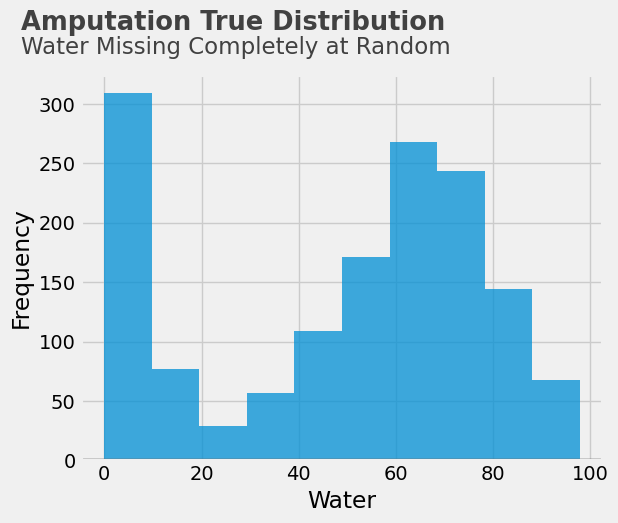

In [23]:
histogram(df = water_df[water_df.water_mcar.isnull()], col = 'water',output_prefix = f'{notebook_nm}',fig_dir = fig_dir, title = 'Amputation True Distribution', subtitle = 'Water Missing Completely at Random', bins = 10, log_scale = False)

Image found in the "reports/figures" folder saved under 3.1-autoencoder-perf-eval_amputation_true_distribution_water_missing_at_random_water_hist.png


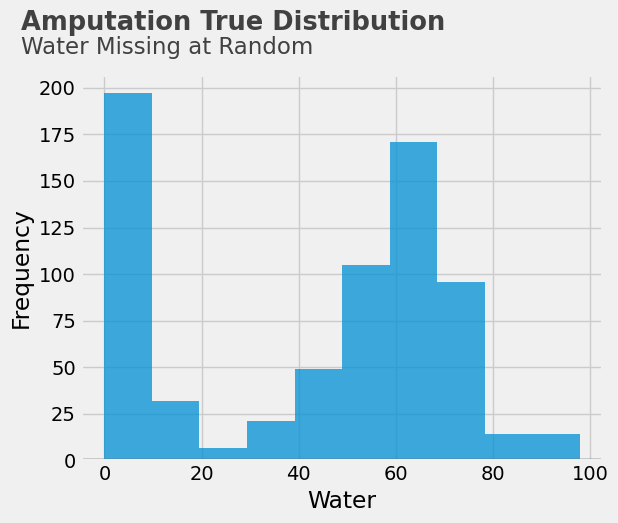

In [24]:
histogram(df = water_df[water_df.water_mar.isnull()], col = 'water',output_prefix = f'{notebook_nm}',fig_dir = fig_dir, title = 'Amputation True Distribution', subtitle = 'Water Missing at Random', bins = 10, log_scale = False)

Image found in the "reports/figures" folder saved under 3.1-autoencoder-perf-eval_amputation_true_distribution_sugar_missing_completely_at_random_sugars_hist.png


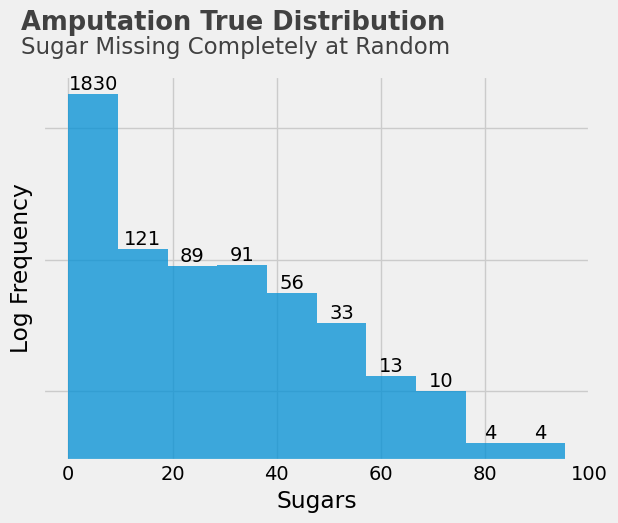

In [26]:
histogram(df = sugars_df[sugars_df.sugars_mcar.isnull()], col = 'sugars',output_prefix = f'{notebook_nm}',fig_dir = fig_dir, title = 'Amputation True Distribution', subtitle = 'Sugar Missing Completely at Random', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 3.1-autoencoder-perf-eval_amputation_true_distribution_sugar_missing_at_random_sugars_hist.png


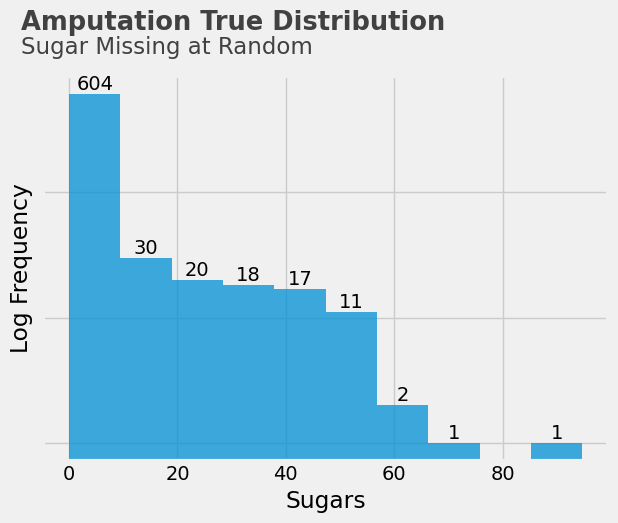

In [27]:
histogram(df = sugars_df[sugars_df.sugars_mar.isnull()], col = 'sugars',output_prefix = f'{notebook_nm}',fig_dir = fig_dir, title = 'Amputation True Distribution', subtitle = 'Sugar Missing at Random', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 3.1-autoencoder-perf-eval_amputation_true_distribution_lutein_missing_completely_at_random_lutein_zeaxanthin_hist.png


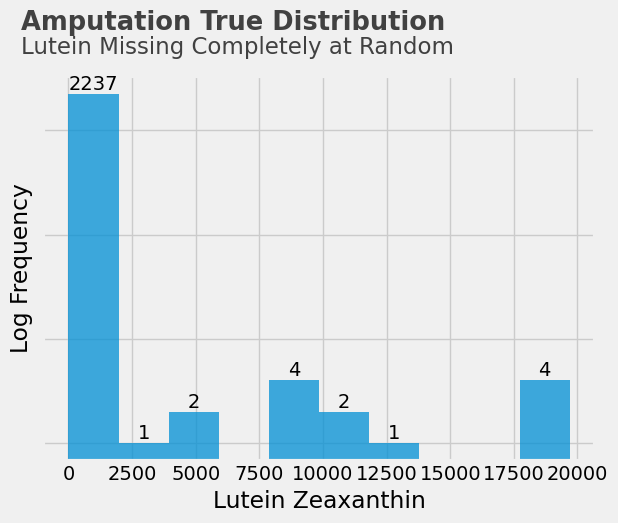

In [28]:
histogram(df = lutein_df[lutein_df.lutein_zeaxanthin_mcar.isnull()], col = 'lutein_zeaxanthin',output_prefix = f'{notebook_nm}',fig_dir = fig_dir, title = 'Amputation True Distribution', subtitle = 'Lutein Missing Completely at Random', bins = 10, log_scale = True)

Image found in the "reports/figures" folder saved under 3.1-autoencoder-perf-eval_amputation_true_distribution_lutein_missing_at_random_lutein_zeaxanthin_hist.png


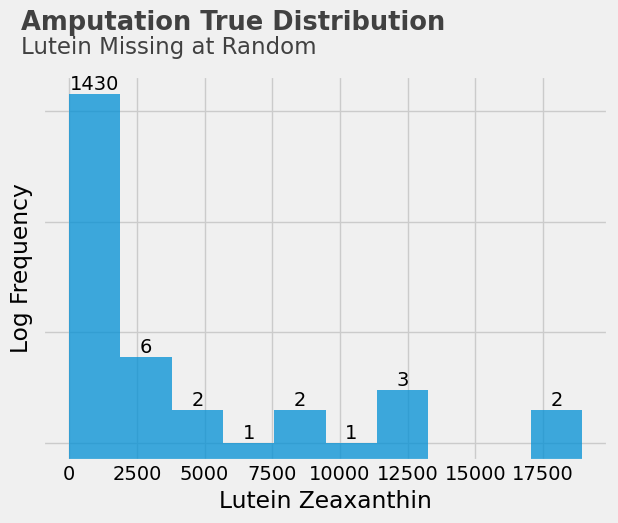

In [29]:
histogram(df = lutein_df[lutein_df.lutein_zeaxanthin_mar.isnull()], col = 'lutein_zeaxanthin',output_prefix = f'{notebook_nm}',fig_dir = fig_dir, title = 'Amputation True Distribution', subtitle = 'Lutein Missing at Random', bins = 10, log_scale = True)